# Time Series Imputation Exploration

#### **upd23b_clinical_state_on_medication Imputation:** 

    Since the variable is categorical I used a one-hot encoding method to represent the 3 possible values ('On', 'Off', NaN). I suspect that NaN is synonimous with 'Off' and if that is found to negatively effect the model we can adjust


#### **updrs_4**

    Imputed using a bayesian regression model on the other variables

#### **updrs_1, updrs_2, updrs_3**

    Imputed using a back fill of previous time series values

## Imports

In [53]:
import sys
sys.path.append("../src")

# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import missingno as mno
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


#Custom packages
from utils import print_missing_vals, plot_correlation_heatmap, plot_feature_distribution


# settings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [54]:
full_clinical_data =pd.read_csv("../data/train_clinical_data.csv")
full_clinical_data = pd.concat([full_clinical_data, pd.get_dummies(full_clinical_data['upd23b_clinical_state_on_medication'], prefix='upd23b_medication')], axis=1)
full_clinical_data = full_clinical_data.drop(['upd23b_clinical_state_on_medication'], axis=1)
clinical_data = full_clinical_data.drop(['patient_id', 'visit_month', 'visit_id'], axis=1)
updrs_data = clinical_data.drop(['upd23b_medication_On', 'upd23b_medication_Off'],axis=1)
peptide_data =pd.read_csv("../data/train_peptides.csv")
protein_data =pd.read_csv("../data/train_proteins.csv")

## Clinical Data

### UPDRS_1

In [55]:
full_clinical_data['updrs_1'].describe()

count    2614.000000
mean        7.110559
std         5.525955
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        33.000000
Name: updrs_1, dtype: float64

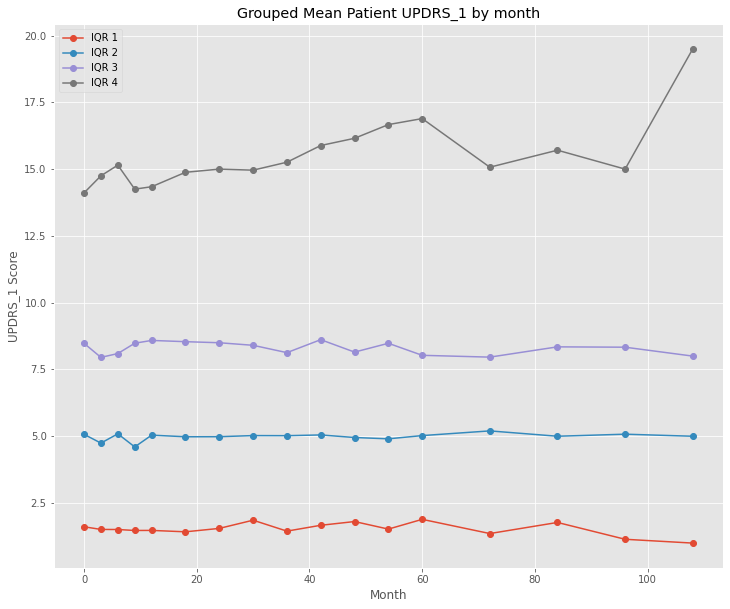

In [56]:
clinical_IQR_1 = full_clinical_data[full_clinical_data['updrs_1'] <= 3]
clinical_IQR_2 = full_clinical_data[(full_clinical_data['updrs_1'] > 3) & (full_clinical_data['updrs_1'] <= 6)]
clinical_IQR_3 = full_clinical_data[(full_clinical_data['updrs_1'] > 6) & (full_clinical_data['updrs_1'] <= 10)]
clinical_IQR_4 = full_clinical_data[full_clinical_data['updrs_1'] > 10]

grouped_iqr_1 = clinical_IQR_1.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_2 = clinical_IQR_2.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_3 = clinical_IQR_3.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_4 = clinical_IQR_4.groupby(['visit_month'], as_index=False).mean()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()

ax.plot(grouped_iqr_1['visit_month'], grouped_iqr_1['updrs_1'], marker='o', label = 'IQR 1')
ax.plot(grouped_iqr_2['visit_month'], grouped_iqr_2['updrs_1'], marker='o', label = 'IQR 2')
ax.plot(grouped_iqr_3['visit_month'], grouped_iqr_3['updrs_1'], marker='o', label = 'IQR 3')
ax.plot(grouped_iqr_4['visit_month'], grouped_iqr_4['updrs_1'], marker='o', label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Mean Patient UPDRS_1 by month")
ax.set_xlabel("Month")
ax.set_ylabel("UPDRS_1 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

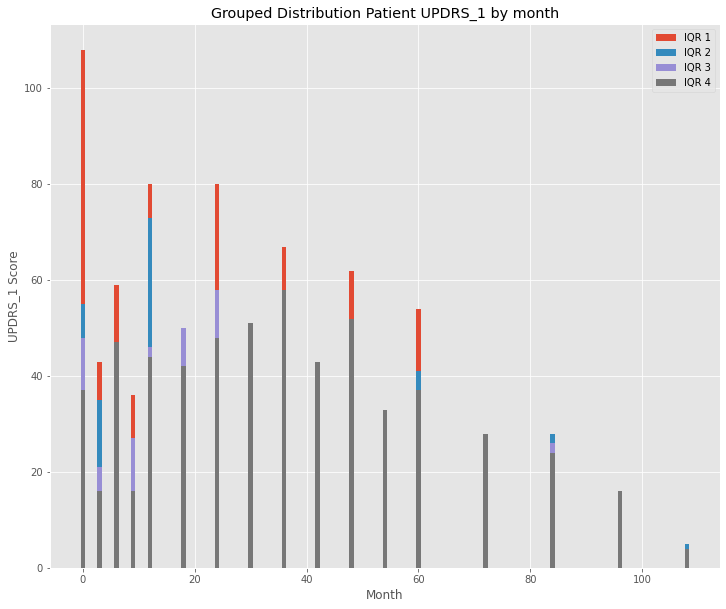

In [57]:
grouped_iqr_1_count = clinical_IQR_1.groupby(['visit_month'], as_index=False).count()
grouped_iqr_2_count = clinical_IQR_2.groupby(['visit_month'], as_index=False).count()
grouped_iqr_3_count = clinical_IQR_3.groupby(['visit_month'], as_index=False).count()
grouped_iqr_4_count = clinical_IQR_4.groupby(['visit_month'], as_index=False).count()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()

ax.bar(grouped_iqr_1_count['visit_month'], grouped_iqr_1_count['updrs_1'], label = 'IQR 1')
ax.bar(grouped_iqr_2_count['visit_month'], grouped_iqr_2_count['updrs_1'], label = 'IQR 2')
ax.bar(grouped_iqr_3_count['visit_month'], grouped_iqr_3_count['updrs_1'], label = 'IQR 3')
ax.bar(grouped_iqr_4_count['visit_month'], grouped_iqr_4_count['updrs_1'], label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Distribution Patient UPDRS_1 by month")
ax.set_xlabel("Month")
ax.set_ylabel("UPDRS_1 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

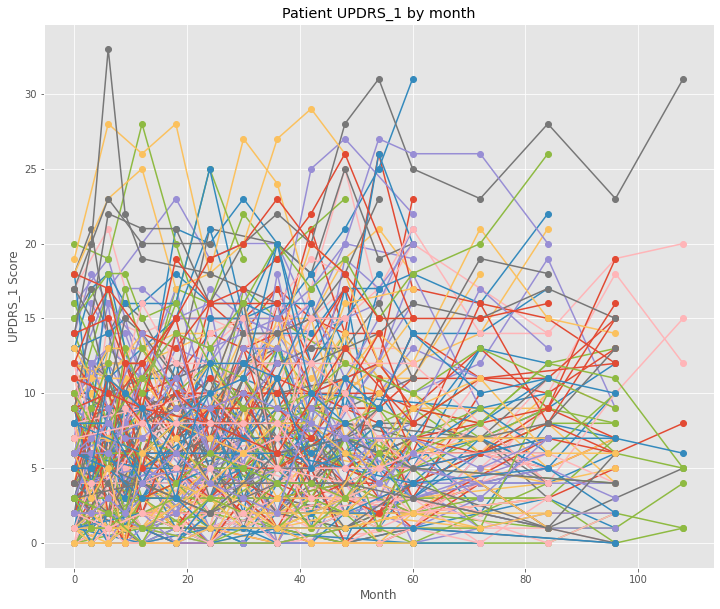

In [58]:
unique_patient_id = full_clinical_data['patient_id'].unique()


plt.figure(figsize=(15,10))
ax = plt.subplot()
for patient in unique_patient_id:
    ax.plot(full_clinical_data[full_clinical_data['patient_id'] == patient]['visit_month'], full_clinical_data[full_clinical_data['patient_id'] == patient]['updrs_1'], label = patient, marker='o')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Patient UPDRS_1 by month")
ax.set_xlabel("Month")
ax.set_ylabel("UPDRS_1 Score")
# ax.set_yscale('log')

plt.show()

### UPDRS_2

In [59]:
full_clinical_data['updrs_2'].describe()

count    2613.00000
mean        6.74359
std         6.32323
min         0.00000
25%         1.00000
50%         5.00000
75%        10.00000
max        40.00000
Name: updrs_2, dtype: float64

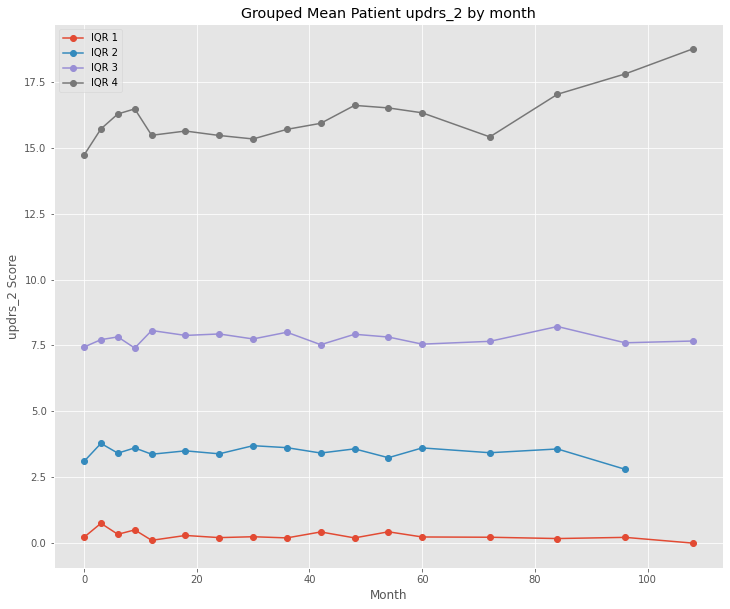

In [60]:
clinical_IQR_1 = full_clinical_data[full_clinical_data['updrs_2'] <= 1]
clinical_IQR_2 = full_clinical_data[(full_clinical_data['updrs_2'] > 1) & (full_clinical_data['updrs_2'] <= 5)]
clinical_IQR_3 = full_clinical_data[(full_clinical_data['updrs_2'] > 5) & (full_clinical_data['updrs_2'] <= 10)]
clinical_IQR_4 = full_clinical_data[full_clinical_data['updrs_2'] > 10]

grouped_iqr_1 = clinical_IQR_1.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_2 = clinical_IQR_2.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_3 = clinical_IQR_3.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_4 = clinical_IQR_4.groupby(['visit_month'], as_index=False).mean()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()

ax.plot(grouped_iqr_1['visit_month'], grouped_iqr_1['updrs_2'], marker='o', label = 'IQR 1')
ax.plot(grouped_iqr_2['visit_month'], grouped_iqr_2['updrs_2'], marker='o', label = 'IQR 2')
ax.plot(grouped_iqr_3['visit_month'], grouped_iqr_3['updrs_2'], marker='o', label = 'IQR 3')
ax.plot(grouped_iqr_4['visit_month'], grouped_iqr_4['updrs_2'], marker='o', label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Mean Patient updrs_2 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_2 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

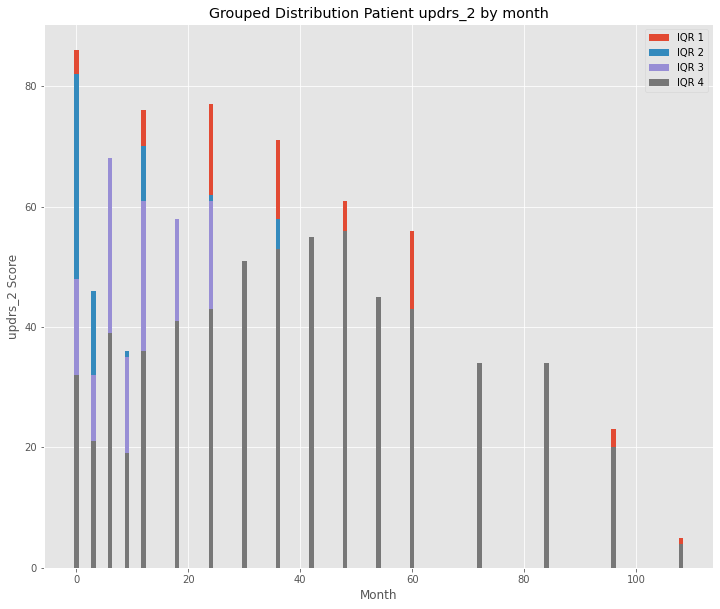

In [61]:
grouped_iqr_1_count = clinical_IQR_1.groupby(['visit_month'], as_index=False).count()
grouped_iqr_2_count = clinical_IQR_2.groupby(['visit_month'], as_index=False).count()
grouped_iqr_3_count = clinical_IQR_3.groupby(['visit_month'], as_index=False).count()
grouped_iqr_4_count = clinical_IQR_4.groupby(['visit_month'], as_index=False).count()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()

ax.bar(grouped_iqr_1_count['visit_month'], grouped_iqr_1_count['updrs_2'], label = 'IQR 1')
ax.bar(grouped_iqr_2_count['visit_month'], grouped_iqr_2_count['updrs_2'], label = 'IQR 2')
ax.bar(grouped_iqr_3_count['visit_month'], grouped_iqr_3_count['updrs_2'], label = 'IQR 3')
ax.bar(grouped_iqr_4_count['visit_month'], grouped_iqr_4_count['updrs_2'], label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Distribution Patient updrs_2 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_2 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

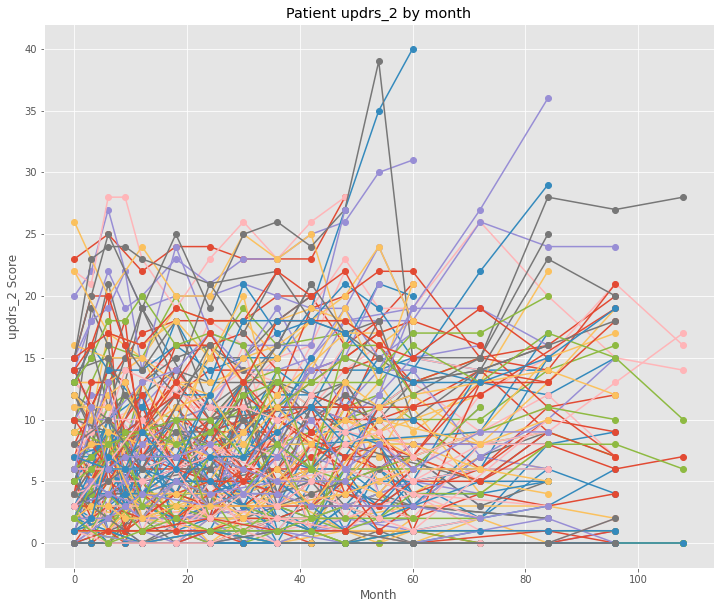

In [62]:
unique_patient_id = full_clinical_data['patient_id'].unique()


plt.figure(figsize=(15,10))
ax = plt.subplot()
for patient in unique_patient_id:
    ax.plot(full_clinical_data[full_clinical_data['patient_id'] == patient]['visit_month'], full_clinical_data[full_clinical_data['patient_id'] == patient]['updrs_2'], label = patient, marker='o')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Patient updrs_2 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_2 Score")
# ax.set_yscale('log')

plt.show()

### UPDRS_3

In [63]:
full_clinical_data['updrs_3'].describe()

count    2590.000000
mean       19.421236
std        15.000289
min         0.000000
25%         6.000000
50%        19.000000
75%        29.000000
max        86.000000
Name: updrs_3, dtype: float64

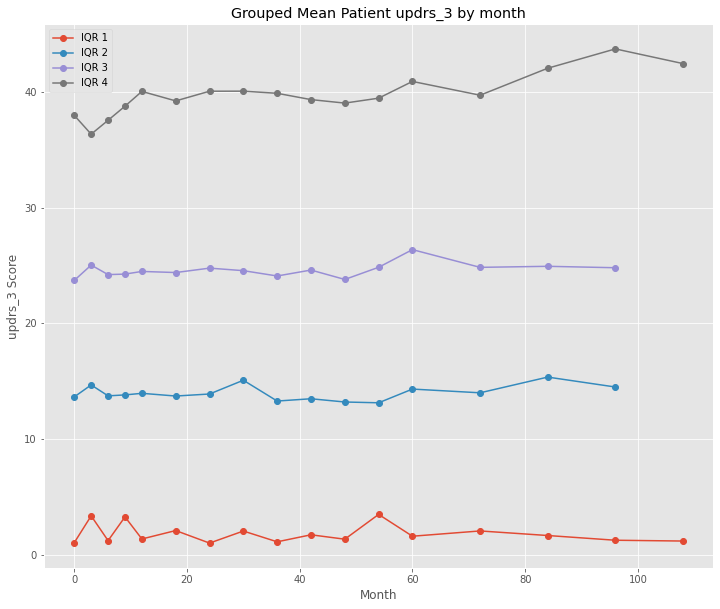

In [64]:
clinical_IQR_1 = full_clinical_data[full_clinical_data['updrs_3'] <= 6]
clinical_IQR_2 = full_clinical_data[(full_clinical_data['updrs_3'] > 6) & (full_clinical_data['updrs_3'] <= 19)]
clinical_IQR_3 = full_clinical_data[(full_clinical_data['updrs_3'] > 19) & (full_clinical_data['updrs_3'] <= 29)]
clinical_IQR_4 = full_clinical_data[full_clinical_data['updrs_3'] > 29]

grouped_iqr_1 = clinical_IQR_1.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_2 = clinical_IQR_2.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_3 = clinical_IQR_3.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_4 = clinical_IQR_4.groupby(['visit_month'], as_index=False).mean()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()

ax.plot(grouped_iqr_1['visit_month'], grouped_iqr_1['updrs_3'], marker='o', label = 'IQR 1')
ax.plot(grouped_iqr_2['visit_month'], grouped_iqr_2['updrs_3'], marker='o', label = 'IQR 2')
ax.plot(grouped_iqr_3['visit_month'], grouped_iqr_3['updrs_3'], marker='o', label = 'IQR 3')
ax.plot(grouped_iqr_4['visit_month'], grouped_iqr_4['updrs_3'], marker='o', label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Mean Patient updrs_3 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_3 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

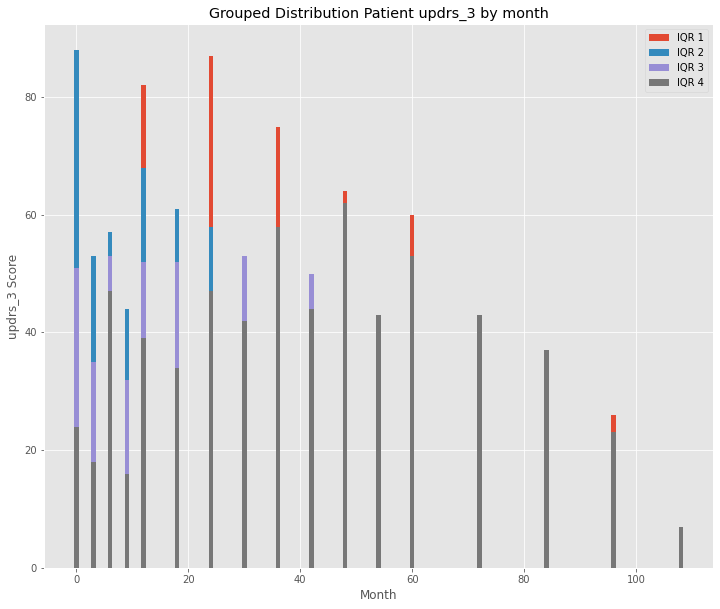

In [65]:
grouped_iqr_1_count = clinical_IQR_1.groupby(['visit_month'], as_index=False).count()
grouped_iqr_2_count = clinical_IQR_2.groupby(['visit_month'], as_index=False).count()
grouped_iqr_3_count = clinical_IQR_3.groupby(['visit_month'], as_index=False).count()
grouped_iqr_4_count = clinical_IQR_4.groupby(['visit_month'], as_index=False).count()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()

ax.bar(grouped_iqr_1_count['visit_month'], grouped_iqr_1_count['updrs_3'], label = 'IQR 1')
ax.bar(grouped_iqr_2_count['visit_month'], grouped_iqr_2_count['updrs_3'], label = 'IQR 2')
ax.bar(grouped_iqr_3_count['visit_month'], grouped_iqr_3_count['updrs_3'], label = 'IQR 3')
ax.bar(grouped_iqr_4_count['visit_month'], grouped_iqr_4_count['updrs_3'], label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Distribution Patient updrs_3 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_3 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

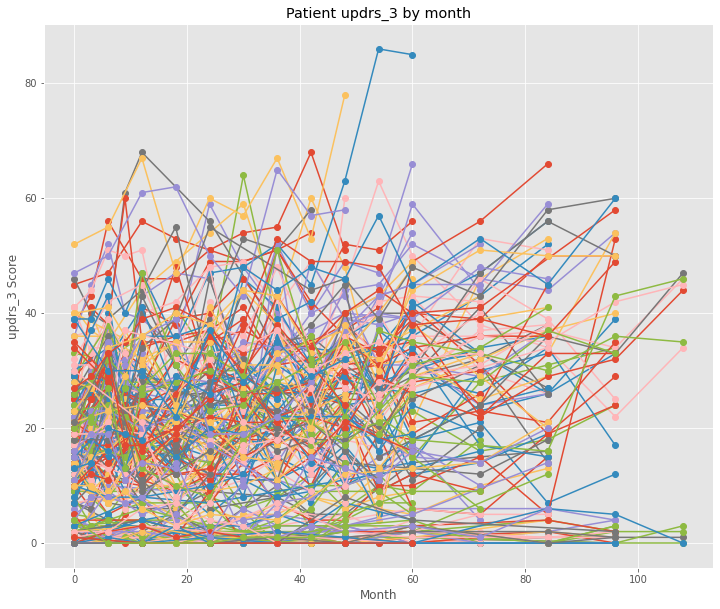

In [66]:
unique_patient_id = full_clinical_data['patient_id'].unique()


plt.figure(figsize=(15,10))
ax = plt.subplot()
for patient in unique_patient_id:
    ax.plot(full_clinical_data[full_clinical_data['patient_id'] == patient]['visit_month'], full_clinical_data[full_clinical_data['patient_id'] == patient]['updrs_3'], label = patient, marker='o')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Patient updrs_3 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_3 Score")
# ax.set_yscale('log')

plt.show()

### UPDRS_4

Using imputed data

In [83]:
imputed_data = pd.read_csv("../data/imputed/train_clinical_imputed.csv")
imputed_data['updrs_4'].describe()

count    2615.000000
mean        1.302103
std         2.496619
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        20.000000
Name: updrs_4, dtype: float64

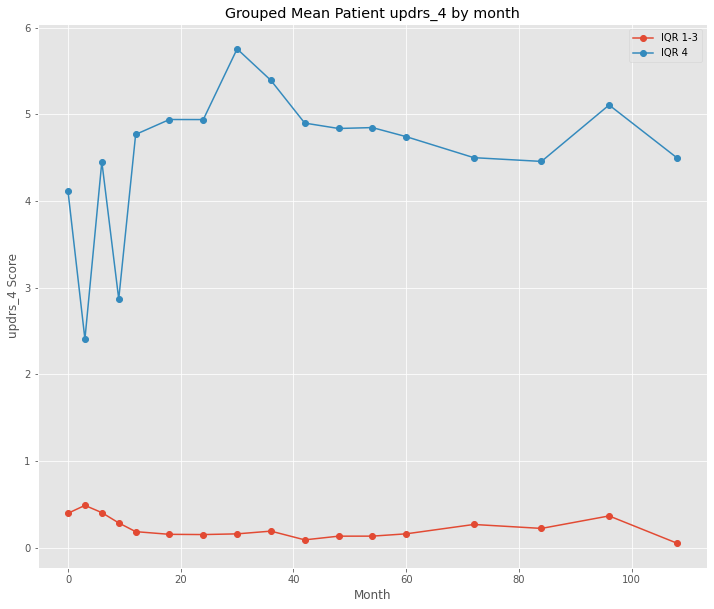

In [73]:
clinical_IQR_3 = imputed_data[(imputed_data['updrs_4'] >= 0) & (imputed_data['updrs_4'] <= 1.512068)]
clinical_IQR_4 = imputed_data[imputed_data['updrs_4'] > 1.512068]


grouped_iqr_3 = clinical_IQR_3.groupby(['visit_month'], as_index=False).mean()
grouped_iqr_4 = clinical_IQR_4.groupby(['visit_month'], as_index=False).mean()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()


ax.plot(grouped_iqr_3['visit_month'], grouped_iqr_3['updrs_4'], marker='o', label = 'IQR 1-3')
ax.plot(grouped_iqr_4['visit_month'], grouped_iqr_4['updrs_4'], marker='o', label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Mean Patient updrs_4 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_4 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

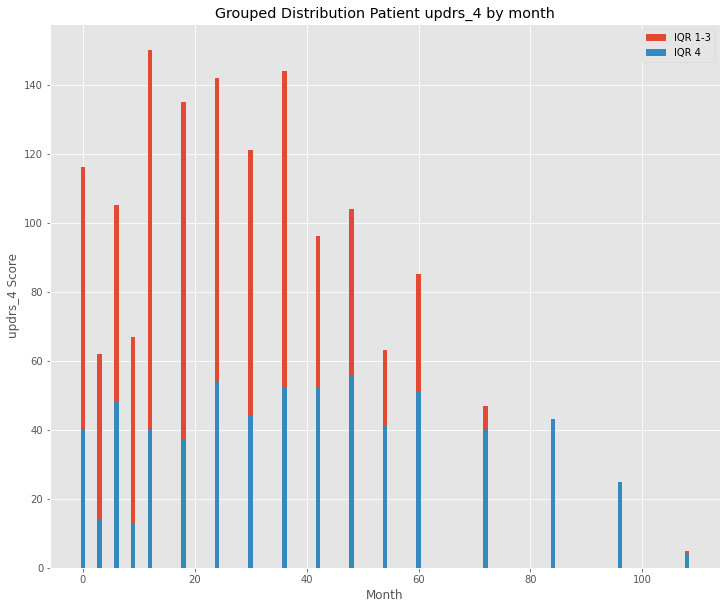

In [74]:

grouped_iqr_3_count = clinical_IQR_3.groupby(['visit_month'], as_index=False).count()
grouped_iqr_4_count = clinical_IQR_4.groupby(['visit_month'], as_index=False).count()
# grouped_iqr_1
plt.figure(figsize=(15,10))
ax = plt.subplot()


ax.bar(grouped_iqr_3_count['visit_month'], grouped_iqr_3_count['updrs_4'], label = 'IQR 1-3')
ax.bar(grouped_iqr_4_count['visit_month'], grouped_iqr_4_count['updrs_4'], label = 'IQR 4')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Grouped Distribution Patient updrs_4 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_4 Score")
ax.legend()
# ax.set_yscale('log')

plt.show()

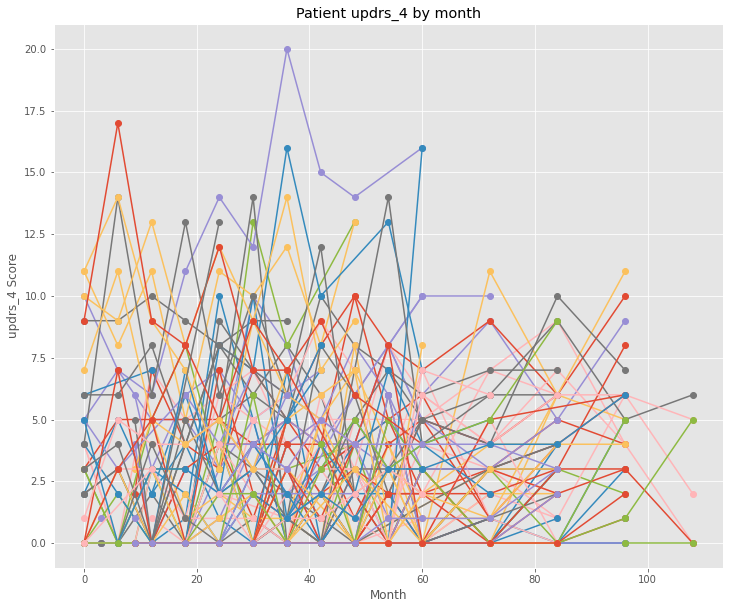

In [75]:
unique_patient_id = full_clinical_data['patient_id'].unique()


plt.figure(figsize=(15,10))
ax = plt.subplot()
for patient in unique_patient_id:
    ax.plot(full_clinical_data[full_clinical_data['patient_id'] == patient]['visit_month'], full_clinical_data[full_clinical_data['patient_id'] == patient]['updrs_4'], label = patient, marker='o')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Patient updrs_4 by month")
ax.set_xlabel("Month")
ax.set_ylabel("updrs_4 Score")
# ax.set_yscale('log')

plt.show()